In [1]:
# Importing nessecary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (15,10)
from scipy.ndimage.interpolation import shift
from collections import deque

In [2]:
# The euler function to determine the first point in the algorithms

def eulerMethod(func,ti,yi,dt,exVel,mass,burnRate,y2=None):
    if not y2:
        initial = func(ti,yi,exVel,mass,-burnRate)
    if y2:
        initial=func(ti,yi,y2[1],exVel,mass,-burnRate)
    return yi + (initial*dt)

In [3]:
def acceleration(ti,yi,exVel,mass,burnRate): # a(t) as described in the lab manual
    part1 = (-exVel/mass)
    return (part1*(-1*burnRate)) - 9.81

def theAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate):
    y0 = yi # the starting point of the rocket
    time = ti+dt 
    firstPoint = eulerMethod(acceleration,ti,yi,dt,exVel,mass,burnRate) # creating the first step using euler method
    finalData = {'Heights':[0,firstPoint],'Times':[0,dt]} # a dictionary to store all values
    
    newMass = mass - (dt*burnRate) # updating mass after first calculation
    liveData = deque([0,firstPoint]) # a live deck storing the two previous steps for each iteration
    while time <= finalTime : # iterating until the final time is reached
        newY = (2*liveData[1]) - (liveData[0]) + ((dt**2)*(acceleration(time,liveData[1],exVel,newMass,burnRate)))#using the verlet method
        finalData['Heights'].append(newY)
        finalData['Times'].append(time)# adding values to the stored data
        time += dt # increasing the time
        newMass -= (dt*burnRate) # updating the mass
        liveData.append(newY)
        del liveData[0] # updating the deque 
    
    return finalData

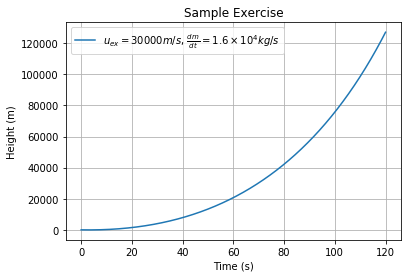

In [4]:
# Sample exercise seen in manual to test the algorithm
data = theAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)
plt.plot(data['Times'],data['Heights'],label=r'$u_{ex} = 30000 m/s$, $\frac{dm}{dt} = 1.6\times 10^4 kg/s$')
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Sample Exercise')
plt.grid(True)
plt.legend();


## Exercise 1
Try running the program for an exhuast velocity of 3000 m/s and a burn time of 200s. Something unusual occurs around 150s, what is this?

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


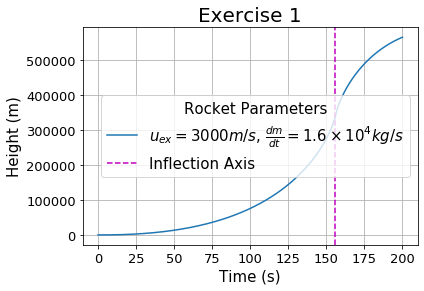

In [5]:
ex1 = theAlgorithm(0,0,0.02,200,3000,2.5e6,1.6e4)
plt.plot(ex1['Times'],ex1['Heights'],label=r'$u_{ex}=3000 m/s$, $\frac{dm}{dt}=1.6\times 10^4 kg/s$')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Height (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.title('Exercise 1',fontsize=20)
plt.grid(True)
plt.axvline(x=156,color='m', linestyle='--',label='Inflection Axis')
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
plt.savefig('Exercise1',format='eps')

At around 150 s (closer to 156s) the trajectory shows a point of inflection. Algebraically this is a point whereby the curvature changes sign. In reality, it shows that the rocket is no longer accelerating and as a result it must mean that the fuel has been consumed and as a result acceleration has stopped. 

## Exercise 2
Try running the program for an exhaust velocity of 1250 m/s and a burn time of 120s. The motion is significantly different; explain what occurs and why/

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


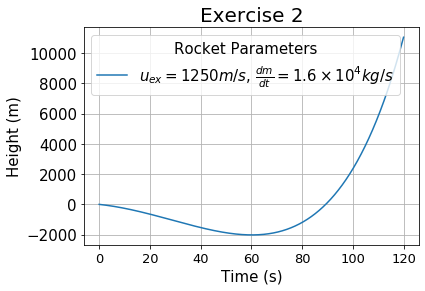

In [6]:
ex2 = theAlgorithm(0,0,0.02,120,1250,2.5e6,1.6e4)
plt.plot(ex2['Times'],ex2['Heights'],label=r'$u_{ex}=1250 m/s$, $\frac{dm}{dt}=1.6\times 10^4 kg/s$')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Height (m)',fontsize=15)
plt.yticks(fontsize=15)
plt.title('Exercise 2',fontsize=20)
plt.grid(True)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
plt.savefig('Exercise2',format='eps')

Clearly there is an issue with the rocket's motion under these conditions, as it suggests that for times up to 60s the rocket is infact falling not rising. A possible explanation for this is that, under these conditions the weight of the rocket is too much for the exhaust velocity and burn rate to lift the rocket and as a result gravity takes over, allowing for the negative heights for the first 60s. 

## Exercise 3
Modify the program to compute velocity from position using $v(t) = \frac{y(t+\Delta t)-y(t-\Delta t)}{2\Delta t}$.  Plot the computer values of v(t) versus time with the theoretical values given by equation (8-71) for an exhaust velocity of 3000 m/s and a burn time of 120s. 

In [7]:
def otherVelocity(exVel,mass,restMass,time):
    part1 = exVel*(np.log(restMass/mass))
    part2 = (-9.81)*time
    return part1 - part2

def velocityModule(data,dt): # creating an additional module to determine velocity using the rocket heights
    velData = {'Velocities':[0],'Times':data['Times']} # make dictionary to store values
    count = 1
    while count <= len(data['Heights'])-2: # for each element take the height of index count+1 and count-1
        y0 = data['Heights'][count-1]      # and use to calculate the velocity, as per equation above
        y2 = data['Heights'][count+1]
        velocity = (y2-y0)/(2*dt)
        velData['Velocities'].append(velocity)
        count += 1   
    return velData


def theVelocityAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate):
    y0 = yi # the starting point of the rocket
    time = ti+dt 
    firstPoint = eulerMethod(acceleration,ti,yi,dt,exVel,mass,burnRate) # creating the first step using euler method
    finalData = {'Heights':[0,firstPoint],'Times':[0,dt]} # a dictionary to store all values
    trueVelocities = {'Velocities':[0,otherVelocity(exVel,mass,mass,time)],'Times':[0,time]}
    
    newMass = mass - (dt*burnRate) # updating mass after first calculation
    liveData = deque([0,firstPoint]) # a deck storing the two previous steps for each iteration
    while time <= finalTime+1 : # iterating until the final time is reached
        newY = (2*liveData[1]) - (liveData[0]) + ((dt**2)*(acceleration(time,liveData[1],exVel,newMass,burnRate)))#using the verlet method
        newV = otherVelocity(exVel,newMass,mass,time)
        finalData['Heights'].append(newY)
        finalData['Times'].append(time)# adding values to the stored data
        trueVelocities['Velocities'].append(newV)
        trueVelocities['Times'].append(time)
        time += dt # increasing the time
        newMass -= (dt*burnRate) # updating the mass
        liveData.append(newY)
        del liveData[0] # updating the deque 
    velocityData = velocityModule(finalData,dt)

    return (velocityData,trueVelocities)

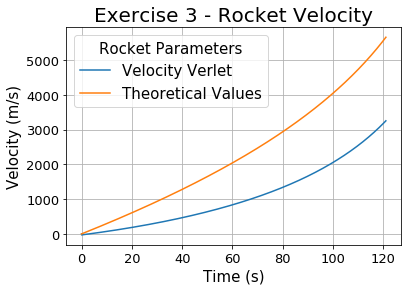

In [8]:
velDict = theVelocityAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)

plt.plot(velDict[0]['Times'][:-1],velDict[0]['Velocities'],label='Velocity Verlet')
plt.plot(velDict[1]['Times'],velDict[1]['Velocities'],label='Theoretical Values')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Velocity (m/s)',fontsize=15)
plt.yticks(fontsize=13)
plt.title('Exercise 3 - Rocket Velocity',fontsize=20)
plt.grid(True)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
#plt.savefig('Exercise3',format='eps')

## Exercise 4
Modify the program to include variable gravitational acceleration, 

$g(y) = g_0 \frac{R^2}{(R+y)^2}$

where R is the radius of Earth and $g_0 = 9.81 m/s$ is the gravitational acceleration at Earth's surface. Plot y(t) versus time or an exhaust velocity of 3000 m/s and a burn time of 120s

In [9]:
def correctAcceleration(ti,yi,exVel,mass,burnRate): # new acceleration function to account for variable gravity
    earthR = 6.3781e6
    part1 = (-exVel/mass)
    part2 = (9.81)*((earthR**2)/((earthR+yi)**2))
    return (part1*(-1*burnRate)) - part2

def theGravityAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate):
    y0 = yi # the starting point of the rocket
    time = ti+dt 
    firstPoint = eulerMethod(correctAcceleration,ti,yi,dt,exVel,mass,burnRate) # creating the first step using euler method
    finalData = {'Heights':[0,firstPoint],'Times':[0,dt]} # a dictionary to store all values
    
    newMass = mass - (dt*burnRate) # updating mass after first calculation
    liveData = deque([0,firstPoint]) # a live deck storing the two previous steps for each iteration
    while time <= finalTime : # iterating until the final time is reached
        newY = (2*liveData[1]) - (liveData[0]) + ((dt**2)*(correctAcceleration(time,liveData[1],exVel,newMass,burnRate)))#using the verlet method
        finalData['Heights'].append(newY)
        finalData['Times'].append(time)# adding values to the stored data
        time += dt # increasing the time
        newMass -= (dt*burnRate) # updating the mass
        liveData.append(newY)
        del liveData[0] # updating the deque 
    
    return finalData

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


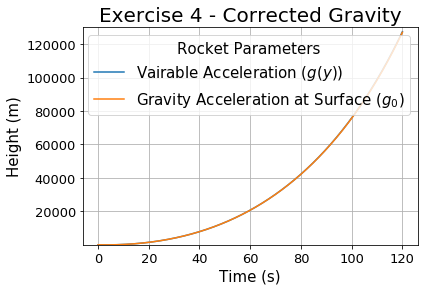

In [10]:
dataAgain = theGravityAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)
oldData = theAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)

plt.plot(dataAgain['Times'],dataAgain['Heights'],label=r'Vairable Acceleration ($g(y)$)')
plt.plot(oldData['Times'],oldData['Heights'], label = r'Gravity Acceleration at Surface ($g_0$)')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Height (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.title('Exercise 4 - Corrected Gravity',fontsize=20)
plt.ylim(1,1.3e5)
plt.grid(True)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
plt.savefig('Exercise4',format='eps')

In [11]:
dataAgain['Heights'][5], oldData['Heights'][5]

(-2.863420347115109, -2.8634203329061907)

## Exercise 5
Modify the program to include drag force,

$F = \frac{1}{2} \rho \nu^2 C_D A$

with $\rho$ being the air density, $A$ as the cross-section of the rocket, $\nu$ as the velocity, and $C_D$ as the drag coefficient. Assume the cross section = 15 $m^2$ and the drag coefficient is 0.30. Plot y(t) versus time for an exhaust velocity of 3000 m/s and a burn time of 120s.

In [12]:
def drag(rho,vel,drag,area,mass): # this function is the equivalent to the the force equation. But it converts the force into an acceleration opposing the rocket (F=ma)
    part1 = rho*(vel**2)*drag*area
    part2 = 2*mass
    return part1/part2


In [26]:
def airDensity(height): # the density of air varies with altitude. Using formulae for the different atomspheric 
                        # regions an array can be created of the densities at different heights
    atmP = 101325
    seaT = 288.15
    g = 9.81
    lapse = 0.0065
    gasConstant = 8.31447
    dryAir = 0.0289654
    U = 18000
    htp = 6.3
    
    if height<18000: # inside troposphere
        part1 =((atmP*dryAir)/(gasConstant*seaT))
        part2 = (1-((lapse*height)/seaT))
        exponent = (((g*dryAir)/(gasConstant*lapse))-1)
        density= part1*(part2**exponent)

    elif height >= 18000 : # outside troposphere

        if height <26000: # inside tropopause
            part1a = (1- ((lapse*U)/seaT))
            part1b = ((g*dryAir)/(gasConstant*lapse))
            part2 = np.exp(-(height-U)/htp)
            density = (part1a**part1b)*part2

        elif height>26000: # in stratosphere
            density = 0 
            
    return density

In [14]:
#def eulerMethod(func,ti,yi,dt,exVel,mass,burnRate,y2=None):

def againAcceleration(ti,yi,velocity,exVel,mass,burnRate): # this acceleration function accounts for both gravity but also the negative acceleration attributed to the drag force
    earthR = 6.3781e6
    part1 = (-exVel/mass)
    part2 = (9.81)*((earthR**2)/((earthR+yi)**2))
    acc = (part1*(-1*burnRate)) - part2
    return acc - drag(airDensity(yi),velocity,0.3,15,mass) # the subtraction allowing for drag


In [15]:
def theBigAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate):
    
    #Part (i) - calculating the heights without considering drag
    finalData = theGravityAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate)
    
    # Part (ii) - calculating velocities (needed for drag calculation)
    velocityData = velocityModule(finalData,dt)
    velocityData['Heights'] = finalData['Heights']
    
    # Part(iii)- correcting heights using drag force
    y0 = yi
    time = ti+dt
    firstHeight = eulerMethod(againAcceleration,ti,yi,dt,exVel,mass,burnRate,y2=(0,0))
    correctData = {'Heights':[0,firstHeight],'Times':[0,time]}
    newMass = mass - (burnRate*dt)
    liveData = deque([0,firstHeight])
    count=1
    iterations = finalTime/dt
    while count< iterations:
        newY = (2*liveData[1])-liveData[0]+((dt**2)*againAcceleration(time,liveData[1],velocityData['Velocities'][count],exVel,mass,burnRate))
        correctData['Heights'].append(newY)
        correctData['Times'].append(time)
        time += dt 
        newMass -= (dt*burnRate) 
        liveData.append(newY)
        del liveData[0] 
        count += 1

    return correctData

127384.05054896045

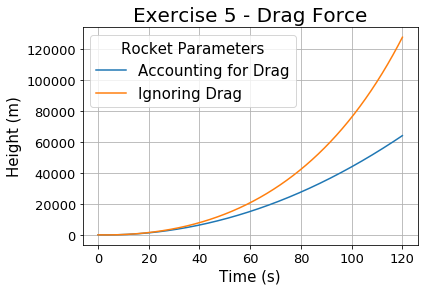

In [16]:
ex5 = theBigAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)
ex5a = theGravityAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)
plt.plot(ex5['Times'],ex5['Heights'],label='Accounting for Drag')
plt.plot(ex5a['Times'],ex5a['Heights'],label='Ignoring Drag')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Height (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.title('Exercise 5 - Drag Force',fontsize=20)
plt.grid(True)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
#plt.savefig('Exercise5',format='eps')
ex5a['Heights'][-1]

In [17]:
#func,ti,yi,dt,exVel,mass,burnRate,y2=None)
eulerMethod(againAcceleration,0,0,0.02,3000,2.5e6,1.6e4,y2=(0,0))

-0.5801999999999999

## Exercise 6
Modify the program to simulate a two stage rocket as described in problem 8-72. Use $m_0 = 2.5\times 10^6 kg$ (total mass of rocket at liftoff); $m_1 = 2.0\times 10^6 kg$ (mass of the fueld in the first stage); $m_{1}' = 2.0\times 10^5 kg$ (mass of the first stage that is discarded) and $m_2 = 2.0 \times 10^5 kg$ (mass of the fueld in the second stage). Plot y(t) versus time for an exhause velocity of 3000 m/s and a burn time sufficient to burn all the fuel.

In [18]:
def theBiggerAlgorithm(ti,yi,dt,finalTime,exVel,totalMass,burnRate,fuelMass1,discardMass,fuelMass2,objectiveMass,step2 = False):
    # objective mass is the mass at which the iterations should stop at i.e. at stage separation
    #Part (i) - calculating the heights without considering drag
    finalData = theBigAlgorithm(ti,yi,dt,finalTime,exVel,totalMass,burnRate)
    
    # Part (ii) - calculating velocities (needed for drag calculation)
    velocityData = velocityModule(finalData,dt)
    velocityData['Heights'] = finalData['Heights']
    
    # Part(iii)- correcting heights using drag force
    y0 = yi
    time = ti+dt
    firstHeight = eulerMethod(againAcceleration,ti,yi,dt,exVel,totalMass,burnRate,y2=(0,yi))
    correctData = {'Heights':[yi,firstHeight],'Times':[ti,time]}
    newMass = totalMass - (burnRate*dt)
    liveData = deque([yi,firstHeight])
    count=2
    sepIndex = 0
    iterations = finalTime/dt
    while count<= iterations:
        newY = (2*liveData[1])-liveData[0]+((dt**2)*againAcceleration(time,liveData[1],velocityData['Velocities'][count],exVel,totalMass,burnRate))
        correctData['Heights'].append(newY)
        correctData['Times'].append(time)
        time += dt 
        newMass -= (dt*burnRate) 
        liveData.append(newY)
        del liveData[0] 
        count += 1
        if newMass == objectiveMass: # break the loop when all the fuel is used (i.e. when newMass = totalmass - fuel1mass, or when newMass = totalmass-fuel1mass-seperatoionmass-fuel2mass)
            break

    if step2: # Using recursion to calculate values after stage separation
        seperationMass = totalMass - fuelMass1-discardMass # total mass when part 1 is discarded
        fuelFinished = totalMass-fuelMass1-discardMass-fuelMass2
        final = theBiggerAlgorithm(time,correctData['Heights'][-1],dt,finalTime,exVel,seperationMass,burnRate,fuelMass1,discardMass,fuelMass2,fuelFinished,step2=True)
        correctData['Times'] += final['Times']
        correctData['Heights'] += final['Heights']

    return correctData

In [19]:
def theBiggestAlgorithm(ti,yi,dt,finalTime,exVel,totalMass,burnRate,fuelMass1,discardMass,fuelMass2,objectiveMass,step2 = False):

    y0 = yi # the starting point of the rocket
    time = ti+dt 
    firstPoint = eulerMethod(correctAcceleration,ti,yi,dt,exVel,totalMass,burnRate) # creating the first step using euler method
    finalData = {'Heights':[0,firstPoint],'Times':[0,dt]} # a dictionary to store all values
    #ignoring drag force by using correctAcceleration function instead of againAcceleration
    
    newMass = totalMass - (dt*burnRate) # updating mass after first calculation
    liveData = deque([0,firstPoint]) # a live deck storing the two previous steps for each iteration
    while newMass>= totalMass-fuelMass1 : # iterating until the final time is reached
        newY = (2*liveData[1]) - (liveData[0]) + ((dt**2)*(correctAcceleration(time,liveData[1],exVel,newMass,burnRate)))#using the verlet method
        finalData['Heights'].append(newY)
        finalData['Times'].append(time)# adding values to the stored data
        time += dt # increasing the time
        newMass -= (dt*burnRate) # updating the mass
        liveData.append(newY)
        del liveData[0] # updating the deque 
    
    # breaking loop and separating rocket using different method
    newMass -= discardMass
    while newMass >= totalMass-fuelMass1-fuelMass2: #continue to iterate until mass of fuel 2 is finished
        otherY = (2*liveData[1]) - (liveData[0]) + ((dt**2)*(correctAcceleration(time,liveData[1],exVel,newMass,burnRate)))#using the verlet method
        finalData['Heights'].append(otherY)
        finalData['Times'].append(time)# adding values to the stored data
        time += dt # increasing the time
        newMass -= (dt*burnRate) # updating the mass
        liveData.append(otherY)
        del liveData[0] # updating the deque 

    return finalData

In [20]:
def wierdAcceleration(ti,yi,velocity,exVel,mass,burnRate): # this acceleration function accounts for both gravity but also the negative acceleration attributed to the drag force
    earthR = 6.3781e6
    return - drag(airDensity(yi),velocity,0.3,15,mass) # the subtraction allowing for drag

def theWierdAlgorithm(ti,yi,dt,finalTime,exVel,totalMass,burnRate,fuelMass1,discardMass,fuelMass2,objectiveMass,step2=False):
    
    #Part (i) - calculating the heights without considering drag
    finalData = theGravityAlgorithm(ti,yi,dt,finalTime,exVel,totalMass,burnRate)
    
    # Part (ii) - calculating velocities (needed for drag calculation)
    velocityData = velocityModule(finalData,dt)
    velocityData['Heights'] = finalData['Heights']
    
    # Part(iii)- correcting heights using drag force
    y0 = yi
    time = ti+dt
    firstHeight = eulerMethod(againAcceleration,ti,yi,dt,exVel,totalMass,burnRate,y2=(0,yi))
    correctData = {'Heights':[yi,firstHeight],'Times':[ti,time]}
    newMass = totalMass - (burnRate*dt)
    liveData = deque([yi,firstHeight])
    count=2
    sepIndex = 0
    iterations = finalTime/dt
    while count<= iterations:
        newY = (2*liveData[1])-liveData[0]+((dt**2)*againAcceleration(time,liveData[1],velocityData['Velocities'][count],exVel,totalMass,burnRate))
        correctData['Heights'].append(newY)
        correctData['Times'].append(time)
        time += dt 
        newMass -= (dt*burnRate) 
        liveData.append(newY)
        del liveData[0] 
        count += 1
        if newMass == totalMass-fuelMass1: # break the loop when all the fuel is used (i.e. when newMass = totalmass - fuel1mass, or when newMass = totalmass-fuel1mass-seperatoionmass-fuel2mass)
            break
            
    # allowing for a 15 second delay during stage separation 
    newMass -= discardMass
    sampleTime = time
    y1 = correctData['Heights'][-1]
    secondHeight = eulerMethod(wierdAcceleration,sampleTime,y1,dt,exVel,totalMass,burnRate,y2=(0,yi))
    otherLiveData = deque([y1,secondHeight])
    while sampleTime<= (time+15):
        otherY = (2*otherLiveData[1])-otherLiveData[0]+((dt**2)*correctAcceleration(sampleTime,otherLiveData[1],exVel,totalMass,burnRate))
        correctData['Heights'].append(otherY)
        correctData['Times'].append(sampleTime)
        sampleTime += dt  
        otherLiveData.append(otherY)
        del otherLiveData[0] 
        
    #resuming iteations after stage separation
    y3 = correctData['Heights'][-1]
    thirdHeight = eulerMethod(againAcceleration,sampleTime,y3,dt,exVel,totalMass,burnRate,y2=(0,yi))
    correctData['Heights'].append(thirdHeight)
    correctData['Times'].append(sampleTime)
    newMass = newMass - (burnRate*dt)
    againLiveData = deque([y3,thirdHeight])
    while newMass>= totalMass-fuelMass1-discardMass-fuelMass2:
        againY = (2*againLiveData[1])-againLiveData[0]+((dt**2)*againAcceleration(sampleTime,againLiveData[1],velocityData['Velocities'][count],exVel,totalMass,burnRate))
        correctData['Heights'].append(againY)
        correctData['Times'].append(sampleTime)
        sampleTime += dt 
        newMass -= (dt*burnRate) 
        againLiveData.append(againY)
        del againLiveData[0] 
        count += 1

        
    return correctData


152.4800000000042

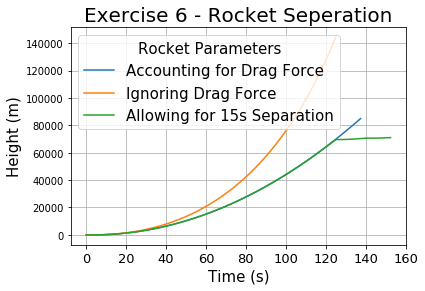

In [21]:
ex6a = theBiggerAlgorithm(0,0,0.02,1000,3000,2.5e6,1.6e4,2e6,2e5,2e5,3e5)
ex6b = theBiggestAlgorithm(0,0,0.02,1000,3000,2.5e6,1.6e4,2e6,2e5,2e5,3e5)
ex6c = theWierdAlgorithm(0,0,0.02,1000,3000,2.5e6,1.6e4,2e6,2e5,2e5,3e5)
plt.plot(ex6a['Times'],ex6a['Heights'],label ='Accounting for Drag Force')
plt.plot(ex6b['Times'],ex6b['Heights'],label= 'Ignoring Drag Force')
plt.plot(ex6c['Times'],ex6c['Heights'],label= 'Allowing for 15s Separation')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Height (m)',fontsize=15)
plt.xticks(fontsize=13)
plt.title('Exercise 6 - Rocket Seperation',fontsize=20)
plt.grid(True)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15);
#plt.savefig('Exercise6',format='eps')
ex6c['Times'][-1]

## Additional Investigations

In [22]:

def otherEuler(func,time,yi,dt,exVel,mass,restMass): # redefining Euler method for this investigation
    part2 = (func(exVel,mass,restMass,time)*dt)
    return yi + part2

def theEulerAlgorithm(ti,yi,dt,finalTime,exVel,mass,burnRate): #
    y0 = yi # the starting point of the rocket
    time = ti+dt 
    firstPoint = otherEuler(otherVelocity,ti,yi,dt,exVel,mass,mass) # creating the first step using euler method
    finalData = {'Heights':[0,firstPoint],'Times':[0,dt]} 
    
    newMass = mass - (dt*burnRate) 
    liveData = deque([0,firstPoint]) 
    while time <= finalTime : 
        newY = otherEuler(otherVelocity,time,liveData[1],dt,exVel,newMass,mass) # same mehtod as before but subsituting verlet for euler method
        finalData['Heights'].append(newY)
        finalData['Times'].append(time)
        time += dt 
        newMass -= (dt*burnRate) 
        liveData.append(newY)
        del liveData[0]  
    
    return finalData

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


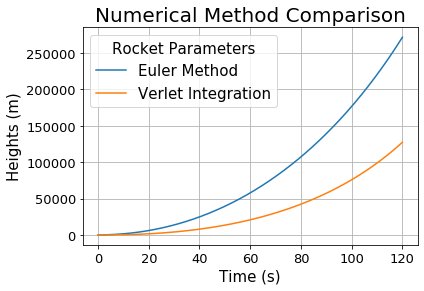

In [23]:
eulerData = theEulerAlgorithm(0,0,0.02,120,3000,2.5e6,1.6e4)
plt.plot(eulerData['Times'],eulerData['Heights'],label='Euler Method')
plt.plot(dataAgain['Times'],dataAgain['Heights'],label='Verlet Integration')
plt.title('Numerical Method Comparison',fontsize=20)
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Heights (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.legend(title="Rocket Parameters", fontsize=15, title_fontsize=15)
plt.grid(True);
plt.savefig('Numerical Method Comparison',format='eps')

1042612.307226719

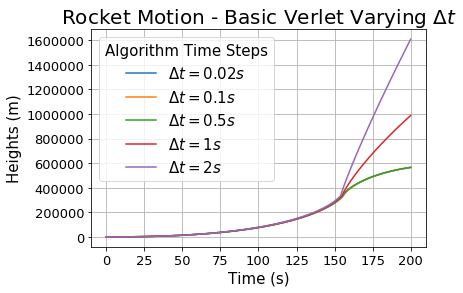

In [24]:
ex7 = theAlgorithm(0,0,0.02,200,3000,2.5e6,1.6e4) # varying step size and plotting
ex7a = theAlgorithm(0,0,0.1,200,3000,2.5e6,1.6e4)
ex7b = theAlgorithm(0,0,0.5,200,3000,2.5e6,1.6e4)
ex7c = theAlgorithm(0,0,1,200,3000,2.5e6,1.6e4)
ex7d = theAlgorithm(0,0,2,200,3000,2.5e6,1.6e4)

plt.plot(ex7['Times'],ex7['Heights'],label=r'$\Delta t = 0.02s$')
plt.plot(ex7a['Times'],ex7a['Heights'],label=r'$\Delta t = 0.1s$')
plt.plot(ex7b['Times'],ex7b['Heights'],label=r'$\Delta t = 0.5s$')
plt.plot(ex7c['Times'],ex7c['Heights'],label=r'$\Delta t = 1s$')
plt.plot(ex7d['Times'],ex7d['Heights'],label=r'$\Delta t = 2s$')

plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Heights (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.title(r'Rocket Motion - Basic Verlet Varying $\Delta t$',fontsize=20)
plt.legend(title="Algorithm Time Steps", fontsize=15, title_fontsize=15)
plt.grid(True);
#plt.savefig('TimeStep1',format='eps')
ex7d['Heights'][-1] - ex7['Heights'][-1]

1930.2463791340415

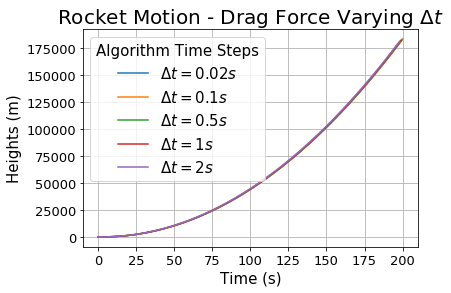

In [25]:
ex7 = theBigAlgorithm(0,0,0.02,200,3000,2.5e6,1.6e4) # varying step size for algorithm accounting for drag force and variable gravity
ex7a = theBigAlgorithm(0,0,0.1,200,3000,2.5e6,1.6e4)
ex7b = theBigAlgorithm(0,0,0.5,200,3000,2.5e6,1.6e4)
ex7c = theBigAlgorithm(0,0,1,200,3000,2.5e6,1.6e4)
ex7d = theBigAlgorithm(0,0,2,200,3000,2.5e6,1.6e4)

plt.plot(ex7['Times'],ex7['Heights'],label=r'$\Delta t = 0.02s$')
plt.plot(ex7a['Times'],ex7a['Heights'],label=r'$\Delta t = 0.1s$')
plt.plot(ex7b['Times'],ex7b['Heights'],label=r'$\Delta t = 0.5s$')
plt.plot(ex7c['Times'],ex7c['Heights'],label=r'$\Delta t = 1s$')
plt.plot(ex7d['Times'],ex7d['Heights'],label=r'$\Delta t = 2s$')
plt.xlabel('Time (s)',fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Heights (m)',fontsize=15)
plt.yticks(fontsize=13)
plt.title(r'Rocket Motion - Drag Force Varying $\Delta t$',fontsize=20)
plt.legend(title="Algorithm Time Steps", fontsize=15, title_fontsize=15)
plt.grid(True);
#plt.savefig('TimeStep2',format='eps')
ex7['Heights'][-1] - ex7d['Heights'][-1]